# APPENDIX 2 - MODELLING

# Preprocess, Modelling and Result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import sklearn as sk
from variable_group import *

In [2]:
# the file is very large, then read some of it
def get_data(name, parent_zip = 'ieee-fraud-detection.zip', nrows = None):
    from zipfile import ZipFile
    with ZipFile(parent_zip, 'r') as f:
        df = pd.read_csv(f.open(name), nrows = nrows, index_col=0)
        
        df['TransactionDay'] = df['TransactionDT'] // (24*60*60)
        df[categorical_cols] = df[categorical_cols].astype('category')
        
    return df

transaction_df = get_data('train_transaction.csv')

In [3]:
def create_test_df(n = 100):
    test_df = transaction_df.head(n).copy()
    return test_df.drop(['isFraud', 'TransactionDT', 'addr2'], axis=1)

test_df = create_test_df(100)
test_df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionDay
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2987001,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2987002,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,287.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2987003,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2987004,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
'''
Notes

The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. Columns of the original feature matrix that are not specified are dropped from the resulting transformed feature matrix, unless specified in the passthrough keyword. Those columns specified with passthrough are added at the right to the output of the transformers.
'''
def MeanTransformer():
    mean_agg =  lambda row : np.mean(row, axis=1).reshape(-1,1) # so that it is 2D
    return FunctionTransformer(mean_agg)

def impute_reduce_pipe(imputer, aggregrator):
    return Pipeline([
        ('impute', imputer),
        ('reduce', aggregrator),
    ])

def vesta_reducer(aggregrator = None):
    if aggregrator is None:
        aggregrator = FunctionTransformer()
    return impute_reduce_pipe(SimpleImputer(strategy='constant', fill_value=-999), aggregrator)

def correlated_group_reducer(subset_group, prefix):
    
    transformers = []
    for i, grp in enumerate(subset_group):
        sz = len(grp)
        if sz <= 1:
            transformers.append((f'{prefix}_{i}', vesta_reducer(), grp))
        # elif sz >= 7: # too slow
        #     vesta_transfomers.append((f'{prefix}_{i}', vesta_reducer(PCA(1)), grp))
        else:
            transformers.append((f'{prefix}_{i}',vesta_reducer(MeanTransformer()), grp))
    return transformers


email_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('encode', OrdinalEncoder())
    ])

vesta_transfomers = correlated_group_reducer(vesta_subset_grp, 'TransV')
count_transformers = correlated_group_reducer(count_feature_subset, 'TransC')
time_transformers = correlated_group_reducer(new_time_subsets, 'TransD')

transfomers = []
transfomers += count_transformers
transfomers += [
    ('identity', vesta_reducer(), ['dist1', 'dist2']), 
    ('log', impute_reduce_pipe(SimpleImputer(strategy='mean'),FunctionTransformer(np.log10)), ['TransactionAmt']),
    # ('KNNImputer1', KNNImputer(), time_features),
    ('cat', OrdinalEncoder(encoded_missing_value=-999), categorical_cols),
]
transfomers += time_transformers
transfomers += vesta_transfomers

def check():
    prv = set(input_features)
    cur = set(flatten_list(trans[2] for trans in transfomers))
    # ensure the set is partition
    assert(len(prv) == len(cur))
    # check if all input features are covered 
    assert(prv.difference(cur) == set()) 
    
    return len(transfomers)
print(check())
preprocessor = ColumnTransformer(transfomers, remainder='drop')

161


In [5]:
# test preprocessor on small data
test_df = create_test_df()
res = preprocessor.fit_transform(test_df)
assert(pd.DataFrame(res).isna().any().sum() == 0) # ensure there is no missing values
res.astype('float'); # ensure all values are float type

In [6]:
# test preprocessor on full data
y = transaction_df['isFraud']

test_df = transaction_df.drop(['isFraud', 'TransactionDT', 'addr2'], axis=1)
X = preprocessor.fit_transform(test_df)
assert(pd.DataFrame(X).isna().any().sum() == 0) # ensure there is no missing values
X.astype('float'); # ensure all values are float type

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
[tmp.shape for tmp in [X_train,y_train,X_test, y_test]]

[(295270, 178), (295270,), (295270, 178), (295270,)]

In [9]:
import xgboost as xgb
import os
import joblib
if 'xgb_1.joblib' in os.listdir('saved_model'):
    clf = joblib.load('saved_model/xgb_1.joblib')
else:
    print('start fitting')
    clf = xgb.XGBClassifier( 
            n_estimators=2000,
            max_depth=10, 
            learning_rate=0.02, 
            subsample=0.8,
            colsample_bytree=0.4, 
            missing=-1, 
            eval_metric='auc',
            tree_method='gpu_hist',
        )
    clf.fit(X_train, y_train)
    joblib.dump(clf, 'saved_model/xgb_1.joblib')

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

start fitting


In [10]:
report = 'train dataset\n'
report += f'f1-score = {sk.metrics.f1_score(y_train, y_train_pred)}\n'
report += sk.metrics.classification_report(y_train, y_train_pred)
report += '\ntest dataset\n'
report += f'f1-score = {sk.metrics.f1_score(y_test, y_test_pred)}\n'
report += sk.metrics.classification_report(y_test, y_test_pred)
with open('model classification report.txt', 'w') as f:
    f.write(report)
print(report)

train dataset
f1-score = 0.8886000541565123
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    285043
           1       1.00      0.80      0.89     10227

    accuracy                           0.99    295270
   macro avg       0.99      0.90      0.94    295270
weighted avg       0.99      0.99      0.99    295270

test dataset
f1-score = 0.6830810383609945
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    284834
           1       0.93      0.54      0.68     10436

    accuracy                           0.98    295270
   macro avg       0.96      0.77      0.84    295270
weighted avg       0.98      0.98      0.98    295270



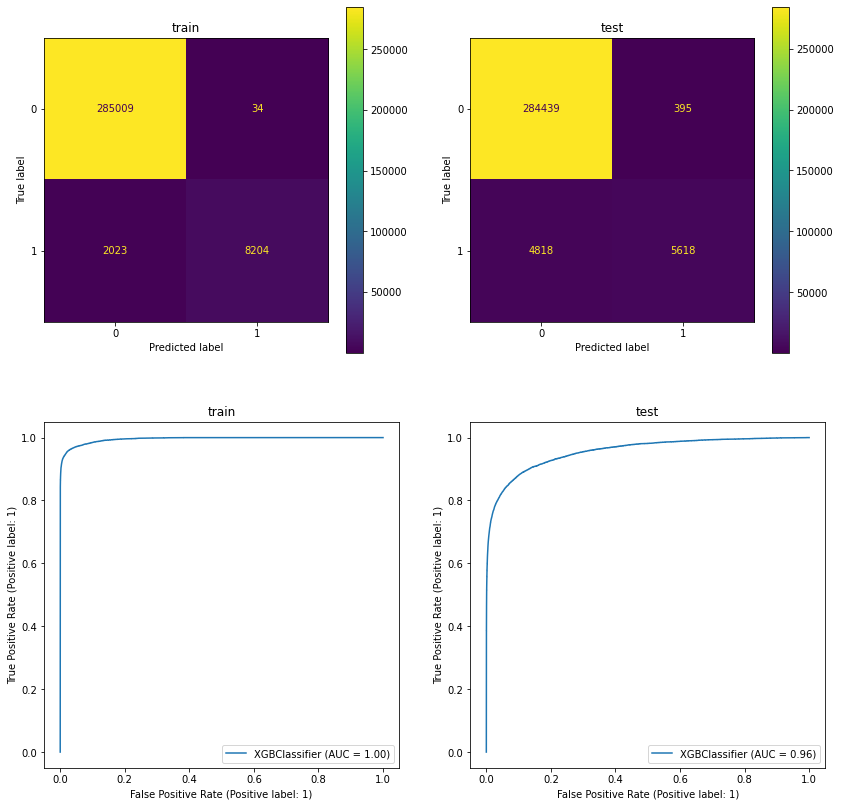

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,14))
axs = axs.flatten()
titles = "train test train test".split()
for ax, t in zip(axs, titles): ax.set_title(t)
axs = iter(axs)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax=next(axs))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=next(axs))
RocCurveDisplay.from_estimator(clf, X_train, y_train, ax=next(axs))
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=next(axs))
fig.savefig('confusion_and_roc.png')

# Creation of Submission File 

In [12]:
test_transaction_df = get_data('test_transaction.csv')

test_dat = test_transaction_df.drop(['TransactionDT', 'addr2'], axis=1)
test_dat = preprocessor.fit_transform(test_dat)
assert(pd.DataFrame(test_dat).isna().any().sum() == 0) # ensure there is no missing values
test_X = test_dat.astype('float')
test_X

MemoryError: Unable to allocate 1.42 GiB for an array with shape (376, 506691) and data type float64

In [ ]:
test_pred_y = clf.predict(test_X)
test_transaction_df['isFraud'] = test_pred_y
test_transaction_df[['isFraud']].to_csv('submission.csv')